In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from tqdm import tqdm

In [2]:
# os.makedirs('new_data', exist_ok=True)
# for year in tqdm(range(2000, 2024)):
#     pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}_totals.html')[0].to_csv(f'new_data/player_{year}.csv', index=False)

In [3]:
def process_year(year):

    # load data
    data = pd.read_csv(f'new_data/player_{year}.csv')

    # get rid of unnecessary rows
    data = data[(data['Player'] != 'Player') & (data['Pos'] != 'Pos')]

    # set season
    data['Season'] = year

    # convert data types to float
    convert_dict = {col: float for col in ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
        '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
        'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
        }
    data = data.astype(
        convert_dict
        
    )

    # drop duplicated rows for players who played for multiple teams, keep the last team they played for
    data = data.sort_values(by='G', ascending=False)
    data = data.drop_duplicates(subset='Player')
    data.reset_index(drop=True, inplace=True)


    return data

In [4]:
players = pd.DataFrame()
for year in tqdm(range(2000, 2024)):
    cur_year = process_year(year)
    players = pd.concat([players, cur_year], ignore_index=True, axis=0)
players

100%|██████████| 24/24 [00:00<00:00, 143.10it/s]


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,144,Chris Gatling,PF,32.0,TOT,85.0,0.0,1811.0,365.0,802.0,...,154.0,348.0,502.0,71.0,82.0,23.0,169.0,246.0,1014.0,2000
1,290,Johnny Newman,SF,36.0,NJN,82.0,9.0,1763.0,278.0,623.0,...,39.0,115.0,154.0,65.0,53.0,11.0,89.0,207.0,820.0,2000
2,421,Chris Whitney,PG,28.0,WAS,82.0,15.0,1627.0,217.0,521.0,...,20.0,114.0,134.0,313.0,55.0,5.0,107.0,166.0,642.0,2000
3,154,A.C. Green,PF,36.0,LAL,82.0,82.0,1929.0,173.0,387.0,...,160.0,326.0,486.0,80.0,53.0,18.0,53.0,127.0,413.0,2000
4,286,Dikembe Mutombo*,C,33.0,ATL,82.0,82.0,2984.0,322.0,573.0,...,304.0,853.0,1157.0,105.0,27.0,269.0,174.0,248.0,942.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11517,233,Frank Jackson,PG,24.0,UTA,1.0,0.0,5.0,0.0,3.0,...,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2023
11518,267,Louis King,PF,23.0,PHI,1.0,0.0,29.0,8.0,13.0,...,2.0,2.0,4.0,2.0,1.0,0.0,2.0,4.0,20.0,2023
11519,98,Chance Comanche,C,26.0,POR,1.0,0.0,21.0,3.0,5.0,...,2.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,7.0,2023
11520,443,Chris Silva,PF,26.0,DAL,1.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2023


In [5]:
players.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Season'],
      dtype='object')

In [6]:
salaries = pd.read_csv(os.path.join('data', 'nba-salaries.csv'))
salaries

,rank,name,position,team,salary,season
0,1,Shaquille O'Neal,C,Los Angeles Lakers,17142000,2000
1,2,Kevin Garnett,PF,Minnesota Timberwolves,16806000,2000
2,3,Alonzo Mourning,C,Miami Heat,15004000,2000
3,4,Juwan Howard,PF,Washington Wizards,15000000,2000
4,5,Scottie Pippen,SF,Portland Trail Blazers,14795000,2000
...,...,...,...,...,...,...
9451,524,Jimmer Fredette,G,Phoenix Suns,208509,2020
9452,525,Jontay Porter,PF,Memphis Grizzlies,197933,2020
9453,526,Anthony Tolliver,PF,Memphis Grizzlies,183115,2020
9454,527,Tyler Johnson,SG,Phoenix Suns,183115,2020


In [7]:
df = players.merge(salaries, left_on=['Player', 'Season'], right_on=['name', 'season'])
seasons = pd.get_dummies(df['Season'], drop_first=True, prefix="season")
teams = pd.get_dummies(df['Tm'], drop_first=True, prefix="team")
positions = pd.get_dummies(df['Pos'], drop_first=True, prefix="position")
df = pd.concat([df, seasons, teams, positions], axis=1)
df
## old data only has 5266 after merging, new data has 7441

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,position_PG-SF,position_PG-SG,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF
0,143,Pat Garrity,SF,23.0,ORL,82.0,1.0,1479.0,258.0,585.0,...,0,0,1,0,0,0,0,0,0,0
1,135,Rick Fox,SF,30.0,LAL,82.0,1.0,1473.0,206.0,498.0,...,0,0,1,0,0,0,0,0,0,0
2,292,Dirk Nowitzki,PF,21.0,DAL,82.0,81.0,2938.0,515.0,1118.0,...,0,0,0,0,0,0,0,0,0,0
3,111,Michael Dickerson,SG,24.0,VAN,82.0,82.0,3103.0,554.0,1270.0,...,0,0,0,0,0,0,1,0,0,0
4,99,Baron Davis,PG,20.0,CHH,82.0,0.0,1523.0,182.0,433.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,321,Luc Mbah a Moute,PF,33.0,HOU,3.0,0.0,25.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
7437,429,Isaiah Roby,PF,21.0,OKC,3.0,0.0,11.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
7438,461,Max Strus,SF,23.0,CHI,2.0,0.0,6.0,2.0,3.0,...,0,0,1,0,0,0,0,0,0,0
7439,527,Tyler Zeller,C,30.0,SAS,2.0,0.0,4.0,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# list(df.columns)

In [9]:
df['3PPerMP'] = df['3P'] / df['MP']
df['PTSPerMP'] = df['PTS'] / df['MP']
df['TRBPerMP'] = df['TRB'] / df['MP']
df['ASTPerMP'] = df['AST'] / df['MP']
df['PFPerMP'] = df['PF'] / df['MP']
df['STLPerMP'] = df['STL'] / df['MP']

In [10]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,7440.000000,7440.000000,7441.000000,7440.000000,7440.000000,7440.000000
mean,0.027276,0.374093,inf,0.080601,0.098198,0.030613
std,0.028896,0.131362,NaN,0.056219,0.042799,0.015310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.290201,0.109819,0.041062,0.070822,0.021422
50%,0.023477,0.365549,0.161538,0.062990,0.089888,0.028981
75%,0.046484,0.447149,0.234605,0.107759,0.117647,0.037975
max,1.000000,3.000000,inf,0.375000,1.000000,0.250000


In [11]:
df[(df['Player']=='Damion James') & (df['Season']==2013)]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,position_SG,position_SG-PF,position_SG-PG,position_SG-SF,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
4519,212,Damion James,SF,25.0,BRK,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,NaN,NaN,inf,NaN,NaN,NaN


<AxesSubplot:ylabel='Frequency'>

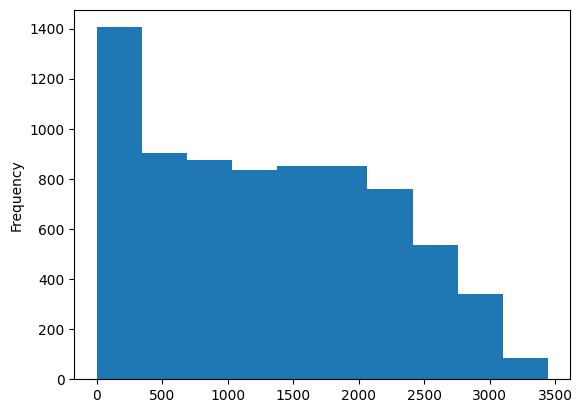

In [19]:
df['MP'].plot(kind='hist')

In [12]:
display(df[df['TRBPerMP'] == np.inf][['TRB', 'MP', 'Player', 'Season']])

df = df[~((df['Player']=='Damion James') & (df['Season']==2013))]
df

,TRB,MP,Player,Season
4519,1.0,0.0,Damion James,2013


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,position_SG,position_SG-PF,position_SG-PG,position_SG-SF,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
0,143,Pat Garrity,SF,23.0,ORL,82.0,1.0,1479.0,258.0,585.0,...,0,0,0,0,0.053414,0.456389,0.141988,0.039216,0.133198,0.020960
1,135,Rick Fox,SF,30.0,LAL,82.0,1.0,1473.0,206.0,498.0,...,0,0,0,0,0.040054,0.362525,0.134420,0.093686,0.137814,0.035302
2,292,Dirk Nowitzki,PF,21.0,DAL,82.0,81.0,2938.0,515.0,1118.0,...,0,0,0,0,0.039483,0.488428,0.181076,0.069095,0.087134,0.021443
3,111,Michael Dickerson,SG,24.0,VAN,82.0,82.0,3103.0,554.0,1270.0,...,1,0,0,0,0.038350,0.482114,0.089913,0.067032,0.072833,0.037383
4,99,Baron Davis,PG,20.0,CHH,82.0,0.0,1523.0,182.0,433.0,...,0,0,0,0,0.016415,0.319107,0.108339,0.202889,0.131976,0.063690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,321,Luc Mbah a Moute,PF,33.0,HOU,3.0,0.0,25.0,2.0,5.0,...,0,0,0,0,0.000000,0.200000,0.080000,0.000000,0.000000,0.080000
7437,429,Isaiah Roby,PF,21.0,OKC,3.0,0.0,11.0,0.0,1.0,...,0,0,0,0,0.000000,0.000000,0.181818,0.000000,0.090909,0.000000
7438,461,Max Strus,SF,23.0,CHI,2.0,0.0,6.0,2.0,3.0,...,0,0,0,0,0.000000,0.833333,0.166667,0.000000,0.166667,0.000000
7439,527,Tyler Zeller,C,30.0,SAS,2.0,0.0,4.0,1.0,4.0,...,0,0,0,0,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000


In [13]:
df['TRB'].describe(), df['MP'].describe()

(count    7440.000000
 mean      226.848387
 std       192.568657
 min         0.000000
 25%        76.000000
 50%       184.000000
 75%       321.000000
 max      1247.000000
 Name: TRB, dtype: float64,
 count    7440.000000
 mean     1301.933199
 std       876.891044
 min         1.000000
 25%       509.750000
 50%      1264.000000
 75%      2008.000000
 max      3443.000000
 Name: MP, dtype: float64)

In [14]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,7440.000000,7440.000000,7440.000000,7440.000000,7440.000000,7440.000000
mean,0.027276,0.374093,0.177318,0.080601,0.098198,0.030613
std,0.028896,0.131362,0.084854,0.056219,0.042799,0.015310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.290201,0.109814,0.041062,0.070822,0.021422
50%,0.023477,0.365549,0.161534,0.062990,0.089888,0.028981
75%,0.046484,0.447149,0.234536,0.107759,0.117647,0.037975
max,1.000000,3.000000,1.500000,0.375000,1.000000,0.250000


In [15]:
# interaction terms
for year in range(2001, 2021):
    df[f'3PPerMPxseason_{year}'] = df['3PPerMP'] * df[f'season_{year}']

/var/folders/4d/_5rfplzd7wq3hcyf5cb9_fhh0000gn/T/ipykernel_26085/846209070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'3PPerMPxseason_{year}'] = df['3PPerMP'] * df[f'season_{year}']


In [16]:
list(df.columns)

['Rk',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Season',
 'rank',
 'name',
 'position',
 'team',
 'salary',
 'season',
 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'team_BOS',
 'team_BRK',
 'team_CHA',
 'team_CHH',
 'team_CHI',
 'team_CHO',
 'team_CLE',
 'team_DAL',
 'team_DEN',
 'team_DET',
 'team_GSW',
 'team_HOU',
 'team_IND',
 'team_LAC',
 'team_LAL',
 'team_MEM',
 'team_MIA',
 'team_MIL',
 'team_MIN',
 'team_NJN',
 'team_NOH',
 'team_NOK',
 'team_NOP',
 'team_NYK',
 'team_OKC',
 'team_ORL',
 'team_PHI',
 'team_PHO',
 'team_POR

In [17]:
independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020'
       ]


#ThreePointersMade/Seconds

X = df[independent_vars]  # Independent variables
y = df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     47.27
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:47:21   Log-Likelihood:            -1.2418e+05
No. Observations:                7440   AIC:                         2.485e+05
Df Residuals:                    7392   BIC:                         2.488e+05
Df Model:                          47                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -3.19e+06   5.08e+05     -6.277      0.000   -4.19e+06   -2.19e+06
GS                   6.408e+04   2248.264     28.502      0.000    5.97e+04    6.85e+04
3PPerMP             -3.057e+07    1.1e+07     -2.766      0.006   -5.22e+07   -8.91e+06
PTSPerMP             8.883e+06   6.28e+05     14.155      0.000    7.65e+06    1.01e+07
TRBPerMP             9.278e+06   1.26e+06      7.391      0.000    6.82e+06    1.17e+07
ASTPerMP             1.227e+07   1.34e+06      9.128      0.000    9.63e+06    1.49e+07
PFPerMP             -6.228e+06   1.59e+06     -3.926      0.000   -9.34e+06   -3.12e+06
STLPerMP            -1.069e+07   3.17e+06     -3.373      0.001   -1.69e+07   -4.48e+06
season_2001          6.973e+04   3.85e+05      0.181      0.856   -6.86e+05    8.25e+05
season_2002          6108.1938   3.82e+05      0.016      0.987   -7.43e+05    7.55e+05
season_2003           8.67e+05   4.48e+05      1.937      0.053   -1.02e+04    1.74e+06
season_2004          1.404e+06   5.25e+05      2.673      0.008    3.75e+05    2.43e+06
season_2005          2.597e+06   6.22e+05      4.178      0.000    1.38e+06    3.81e+06
season_2006          6.798e+05   3.96e+05      1.717      0.086   -9.63e+04    1.46e+06
season_2007          5.506e+05   3.84e+05      1.434      0.151   -2.02e+05     1.3e+06
season_2008          4.106e+05   3.95e+05      1.038      0.299   -3.64e+05    1.19e+06
season_2009          6.778e+05   4.19e+05      1.617      0.106   -1.44e+05     1.5e+06
season_2010          6.343e+05   4.11e+05      1.544      0.123   -1.71e+05    1.44e+06
season_2011           9.19e+05   4.05e+05      2.267      0.023    1.24e+05    1.71e+06
season_2012          1.058e+06   3.97e+05      2.663      0.008    2.79e+05    1.84e+06
season_2013          6.631e+05   4.01e+05      1.653      0.098   -1.23e+05    1.45e+06
season_2014          1.023e+06   4.27e+05      2.398      0.016    1.87e+05    1.86e+06
season_2015          5.979e+05   4.17e+05      1.433      0.152    -2.2e+05    1.42e+06
season_2016          7.966e+05   4.49e+05      1.773      0.076   -8.38e+04    1.68e+06
season_2017          1.658e+06   5.11e+05      3.242      0.001    6.56e+05    2.66e+06
season_2018           4.06e+06   5.67e+05      7.160      0.000    2.95e+06    5.17e+06
season_2019          1.391e+06   7.02e+05      1.982      0.047    1.56e+04    2.77e+06
season_2020          2.078e+06   7.12e+05      2.919      0.004    6.83e+05    3.47e+06
3PPerMPxseason_2001  1.187e+07    1.3e+07      0.914      0.361   -1.36e+07    3.73e+07
3PPerMPxseason_2002  1.719e+07   1.26e+07      1.362      0.173   -7.54e+06    4.19e+07
3PPerMPxseason_2003  7.624e+06   1.62e+07      0.469      0.639   -2.42e+07    3.95e+07
3PPerMPxseason_2004  2.523e+07    1.9e+07      1.327      0.185    -1.2e+07    6.25e+07
3PP

In [ ]:
'3PPerMP'

In [18]:
df[['GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].corr()

,GS,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
GS,1.000000,0.064032,0.366076,0.033259,0.199685,-0.314846,0.055708
3PPerMP,0.064032,1.000000,0.414664,-0.448217,0.208619,-0.345316,0.040983
PTSPerMP,0.366076,0.414664,1.000000,-0.013830,0.213843,-0.274983,0.022471
TRBPerMP,0.033259,-0.448217,-0.013830,1.000000,-0.426893,0.335536,-0.170546
ASTPerMP,0.199685,0.208619,0.213843,-0.426893,1.000000,-0.345566,0.310284
PFPerMP,-0.314846,-0.345316,-0.274983,0.335536,-0.345566,1.000000,-0.091399
STLPerMP,0.055708,0.040983,0.022471,-0.170546,0.310284,-0.091399,1.000000


In [ ]:
# subtract points made from 3 from total points